# Cisco - Ariel University API Security Detection Challenge 2023


---



---



## Dataset 3 (Task 3) - Attack Type phase

Same as before but this time the dataset includes more complex parameters in any request making it more authentic but also making it much harder to simply "plug and play" on any machine learning model. According to the model you choose some of you may need to approach the data exploration and feature extraction differently.

```
Dataset 3 score - Attack Type phase:

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     22667
           1    1.00000   1.00000   1.00000       575
           2    1.00000   1.00000   1.00000       272
           3    1.00000   1.00000   1.00000       278
           4    1.00000   1.00000   1.00000       287
           5    1.00000   1.00000   1.00000       285
           6    1.00000   1.00000   1.00000       560
           7    1.00000   1.00000   1.00000       581

    accuracy                        1.00000     25505
   macro avg    1.00000   1.00000   1.00000     25505
weighted avg    1.00000   1.00000   1.00000     25505
```

[Link to the Dataset 3](https://drive.google.com/file/d/15MxHRAdwPXCENACwn8wLMkb98ZCjDeh6/view?usp=share_link
)

## Baseline code

### Imports and global settings


In [ ]:
# Imports, settings and first dataset view
from sklearn.svm import SVC
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import TruncatedSVD

import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps
import matplotlib.pyplot as plt
import plotly.io as pio
pio.templates.default = "plotly_dark"
pio.templates['plotly_dark'].layout.autosize = False
pio.templates['plotly_dark'].layout.width = 1_000
pio.templates['plotly_dark'].layout.height = 800

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import make_scorer, recall_score

from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import StackingClassifier

from urllib.parse import urlparse

import pickle

# from ipywidgets import widgets

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 3  # Options are [1, 2, 3, 4]
test_type = 'attack_type'  # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly
df.head()

### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns
# You can use this snippet to run your own lambda on any data with the apply() method

def categorize(row):
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'


df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",NaN,NaN,NaN,NaN,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144495,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) G...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=CUsow_eOa54yp9oNsd1BhZF2lKtgt-PGMG7iBnLba...,"Thu, 15 Dec 2022 00:49:47 GMT",GET,http://127.0.0.1:5000/?res_id=kc66M-9P2z2nOc6C...,,200 OK,text/html; charset=utf-8,34,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
144496,127.0.0.1:5000,python-requests/2.28.1,"gzip, deflate",*/*,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GET,http://127.0.0.1:5000/bookstore,,200 OK,application/json,41,200,"{""message"": ""Welcome to the Book Store!""}",NaN,NaN,NaN,NaN,Benign,Benign
144497,127.0.0.1:5000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=wo-zV78-fKpHPJjNrkXs_EyYZNCJ_VErr0hf4O8l1...,"Thu, 15 Dec 2022 00:47:04 GMT",GET,http://127.0.0.1:5000/greet/Manuel,,200 OK,text/html; charset=utf-8,22,200,text/html; charset=utf-8,NaN,NaN,NaN,NaN,Benign,Benign
144498,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=2mYff-_R_5fjojY_G5JZQ1uiY-WO6gdfN09c9nH_R...,"Thu, 15 Dec 2022 00:42:00 GMT",GET,http://127.0.0.1:5000/orders/get/random/6,,200 OK,application/json,20,200,"[{}, {}, {}, {}, {}, {}]",NaN,NaN,NaN,NaN,Benign,

In [3]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   request.headers.Host             144500 non-null  object
 1   request.headers.User-Agent       144500 non-null  object
 2   request.headers.Accept-Encoding  144500 non-null  object
 3   request.headers.Accept           144500 non-null  object
 4   request.headers.Connection       144500 non-null  object
 5   request.headers.Accept-Language  129210 non-null  object
 6   request.headers.Sec-Fetch-Site   129210 non-null  object
 7   request.headers.Sec-Fetch-Mode   129210 non-null  object
 8   request.headers.Sec-Fetch-User   129210 non-null  object
 9   request.headers.Sec-Fetch-Dest   129210 non-null  object
 10  request.headers.Set-Cookie       129210 non-null  object
 11  request.headers.Date             129210 non-null  object
 12  request.method  

In [4]:
# Check for correlated features
print(df.corr())

                      response.status_code
response.status_code                   1.0


/tmp/ipykernel_68056/1658926091.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


In [5]:
# Minimum number of unique values to print value counts for
min_unique_values = 10

# Check the distribution of categories within each categorical feature
for column in df.columns:
  if df[column].dtype == 'object' and df[column].nunique() >= min_unique_values:
    print(f'{column}:')
    print(df[column].value_counts())

request.headers.User-Agent:
python-requests/2.28.1                                                                                                       15290
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                         4076
Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36                     4030
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36                       4021
Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko/20100101 Firefox/28.0                                                          4000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36     3999
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36               3998
Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25.0) Gecko

In [6]:
# List of columns to focus on
columns_to_focus_on = ['request.headers.User-Agent', 'request.headers.Sec-Fetch-Site']

# Check the distribution of categories within each categorical feature
for column in columns_to_focus_on:
  if df[column].dtype == 'object':
    print(f'{column}:')
    print(df[column].value_counts())

request.headers.User-Agent:
python-requests/2.28.1                                                                                                       15290
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                         4076
Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36                     4030
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36                       4021
Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko/20100101 Firefox/28.0                                                          4000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36     3999
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36               3998
Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25.0) Gecko

In [7]:
# Check the distribution of categories within each categorical feature
for column in df.columns:
  if df[column].dtype == 'object':
    print(f'{column}:')
    print(df[column].value_counts())

request.headers.Host:
127.0.0.1:5000    144500
Name: request.headers.Host, dtype: int64
request.headers.User-Agent:
python-requests/2.28.1                                                                                                       15290
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36                         4076
Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36                     4030
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36                       4021
Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko/20100101 Firefox/28.0                                                          4000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36     3999
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 

In [9]:
# Check the balance of the target classes
print(df['label'].value_counts())

Benign     128420
Malware     16080
Name: label, dtype: int64


In [10]:
# Check the proportion of missing values in each feature
print(df.isnull().mean())

request.headers.Host               0.000000
request.headers.User-Agent         0.000000
request.headers.Accept-Encoding    0.000000
request.headers.Accept             0.000000
request.headers.Connection         0.000000
request.headers.Accept-Language    0.105813
request.headers.Sec-Fetch-Site     0.105813
request.headers.Sec-Fetch-Mode     0.105813
request.headers.Sec-Fetch-User     0.105813
request.headers.Sec-Fetch-Dest     0.105813
request.headers.Set-Cookie         0.105813
request.headers.Date               0.105813
request.method                     0.000000
request.url                        0.000000
request.body                       0.000000
response.status                    0.000000
response.headers.Content-Type      0.000000
response.headers.Content-Length    0.000000
response.status_code               0.000000
response.body                      0.000000
request.headers.Content-Length     0.952872
response.headers.Location          0.940547
request.headers.Cookie          

In [11]:
# Check the distribution of numerical features
print(df.describe())

       response.status_code
count         144500.000000
mean             279.095370
std              100.875258
min              200.000000
25%              200.000000
50%              200.000000
75%              401.000000
max              500.000000


In [12]:
# Check the number of unique values in each feature
print(df.nunique())

request.headers.Host                    1
request.headers.User-Agent             34
request.headers.Accept-Encoding       268
request.headers.Accept                  1
request.headers.Connection              1
request.headers.Accept-Language         4
request.headers.Sec-Fetch-Site        278
request.headers.Sec-Fetch-Mode          2
request.headers.Sec-Fetch-User          1
request.headers.Sec-Fetch-Dest        245
request.headers.Set-Cookie         121917
request.headers.Date                 3154
request.method                          2
request.url                         75445
request.body                          201
response.status                         7
response.headers.Content-Type           2
response.headers.Content-Length      2079
response.status_code                    7
response.body                        7393
request.headers.Content-Length         14
response.headers.Location            5313
request.headers.Cookie                 38
response.headers.Set-Cookie       

In [13]:
# Check the data types of the features
print(df.dtypes)

request.headers.Host               object
request.headers.User-Agent         object
request.headers.Accept-Encoding    object
request.headers.Accept             object
request.headers.Connection         object
request.headers.Accept-Language    object
request.headers.Sec-Fetch-Site     object
request.headers.Sec-Fetch-Mode     object
request.headers.Sec-Fetch-User     object
request.headers.Sec-Fetch-Dest     object
request.headers.Set-Cookie         object
request.headers.Date               object
request.method                     object
request.url                        object
request.body                       object
response.status                    object
response.headers.Content-Type      object
response.headers.Content-Length    object
response.status_code                int64
response.body                      object
request.headers.Content-Length     object
response.headers.Location          object
request.headers.Cookie             object
response.headers.Set-Cookie       

### Preprocessing Data


In [14]:
list_of_nan_for_more_than_90 = []
for col in df.columns:
    if df[col].isna().sum() / df.shape[0] * 100 > 90:
        list_of_nan_for_more_than_90.append(col)
        print(f"Column {col} has {df[col].isna().sum()} NaN values, which is {round(df[col].isna().sum() / df.shape[0] * 100, 2)}%, and has {df[col].nunique()} unique values")

Column request.headers.Content-Length has 137690 NaN values, which is 95.29%, and has 14 unique values
Column response.headers.Location has 135909 NaN values, which is 94.05%, and has 5313 unique values
Column request.headers.Cookie has 141247 NaN values, which is 97.75%, and has 38 unique values
Column response.headers.Set-Cookie has 142861 NaN values, which is 98.87%, and has 1 unique values


In [15]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')

# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=yGkqVSrlAG5SQ_fZmLWaNcmRrpqyDTqyfly6jHH51...,"Wed, 14 Dec 2022 23:59:27 GMT",GET,http://127.0.0.1:5000/greet/%7B%7Bget_flashed_...,,200 OK,text/html; charset=utf-8,48,200,text/html; charset=utf-8,None,None,None,None,RCE,Malware
1,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,same-origin,?1,document,['ck=CBhNqYCEwU1hN4CAD575di_4AcXDmw9CJAmtkmnri...,"Thu, 15 Dec 2022 00:36:21 GMT",GET,http://127.0.0.1:5000/about/greet?id=8730419.2...,,200 OK,text/html; charset=utf-8,93,200,text/html; charset=utf-8,None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=ZQg8nVqE2_D3CUsmSgDblTxzOkazD7RURCvUUcty_...,"Thu, 15 Dec 2022 00:47:40 GMT",GET,http://127.0.0.1:5000/static/download_txt/Inez...,,200 OK,application/json,88,200,"{""error"": ""File Inez.txtfilename=0MGnu5_DtpSPy...",None,None,None,None,Benign,Benign
3,127.0.0.1:5000,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.9,he;q=0.8",none,websocket,?1,document,['ck=3bV7UJGya8WbsvLb5oZMQfCX_kAxzzmCNHYnBZ6gd...,"Thu, 15 Dec 2022 00:45:52 GMT",GET,http://127.0.0.1:5000/categories/check/all?res...,,200 OK,application/json,871,200,"[{""category_id"": ""1"", ""category_name"": ""Bevera...",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,"gzip, deflate, br",*/*,keep-alive,de,none,websocket,?1,document,['ck=GYA_AaxVnjLo7_TMm5qDgaJwuKEWzzJ3SU3UlNLqY...,"Thu, 15 Dec 2022 00:48:06 GMT",GET,http://127.0.0.1:5000/orders/get/id/4581?id=62...,,404 NOT FOUND,application/json,31,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign


In [16]:
# Detect columns that have the same value for all rows and print them
from collections import Counter
for column in df.columns:
    if len(Counter(df[column])) == 1:
        print(column)

request.headers.Host
request.headers.Accept
request.headers.Connection


In [17]:
# Check features

# Create a correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Columns to drop: {to_drop}")

Columns to drop: []


/tmp/ipykernel_68056/1757241736.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()
/tmp/ipykernel_68056/1757241736.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [18]:
# Create new features from URL
# Search for '$' in the headers

def create_features(df):
    df['url_path'] = df.apply(lambda x: urlparse(x["request.url"]).path, axis=1)
    df['url_query'] = df.apply(lambda x: urlparse(x["request.url"]).query, axis=1)
    df['url_netloc'] = df.apply(lambda x: urlparse(x["request.url"]).netloc, axis=1)
    df['url_scheme'] = df.apply(lambda x: urlparse(x["request.url"]).scheme, axis=1)
    df['url_length'] = df.apply(lambda x: len(x["request.url"]), axis=1)
    df['url_path_length'] = df.apply(lambda x: len(x["url_path"]), axis=1)
    df['url_query_length'] = df.apply(lambda x: len(x["url_query"]), axis=1)
    df['url_netloc_length'] = df.apply(lambda x: len(x["url_netloc"]), axis=1)

    # If the URL contains a double dot, it is probably a malicious URL because it is a directory traversal attack.
    df['url_contains_..'] = df.apply(lambda x: True if '..' in x["request.url"] else False, axis=1)

    # If the URL contains ... it is probably a malicious URL because it is a directory traversal attack.
    df['url_contains_...'] = df.apply(lambda x: True if '...' in x["request.url"] else False, axis=1)

    # If an absolute file path is provided in the input parameters, it may be an indication that the attacker is attempting to access files outside of the intended directory structure.
    df['url_contains_://'] = df.apply(lambda x: True if '://' in x["request.url"] else False, axis=1)

    # Null characters can be used to bypass input validation and may be an indicator of an attempt to traverse the directory tree.
    df['url_contains_%00'] = df.apply(lambda x: True if '%00' in x["url_query"] else False, axis=1)

    # If the URL contains carriage return character, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_%0D'] = df.apply(lambda x: True if '%0D' in x["url_query"] else False, axis=1)

    # If the URL contains a line feed character, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_%0A'] = df.apply(lambda x: True if '%0A' in x["url_query"] else False, axis=1)

    # To detect LOG4J attacks, check for the presence of the log4j string in the data.
    df['url_contains_log4j'] = df.apply(lambda x: True if 'log4j' in x["url_query"] else False, axis=1)

    # If the URL contains a dollar sign, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_$'] = df.apply(lambda x: True if '$' in x["request.url"] else False, axis=1)

    # If the URL contains a backslash, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_\\'] = df.apply(lambda x: True if '\\' in x["request.url"] else False, axis=1)

    # If the URL contains SQL keywords, it is probably a malicious URL because it is a SQL injection attack.
    SQL_keywords = ['SELECT', 'FROM', 'WHERE', 'DROP', 'INSERT', 'UPDATE', 'DELETE', 'CREATE', 'ALTER', 'TABLE', 'DATABASE', 'UNION', 'JOIN', 'ORDER BY', 'GROUP BY', 'HAVING', 'LIMIT', 'OFFSET', 'AND', 'OR', 'NOT', 'IN', 'LIKE', 'BETWEEN', 'IS NULL', 'IS NOT NULL', 'EXISTS', 'CASE', 'WHEN', 'THEN', 'ELSE', 'END', 'AS', 'ASC', 'DESC', 'ALL', 'ANY', 'SOME', 'DISTINCT', 'INTO', 'VALUES', 'TRUNCATE', 'REPLACE', 'RENAME', 'ROLLBACK', 'COMMIT', 'SAVEPOINT', 'GRANT', 'REVOKE', 'LOCK', 'UNLOCK', 'VIEW', 'INDEX', 'PRIMARY KEY', 'FOREIGN KEY', 'UNIQUE', 'CHECK', 'DEFAULT', 'REFERENCES', 'CONSTRAINT', 'TRIGGER', 'PROCEDURE', 'FUNCTION', 'BEGIN', 'DECLARE', 'CURSOR', 'FETCH', 'CLOSE', 'EXECUTE', 'HANDLER', 'LOAD', 'DATA', 'INFILE', 'INTO', 'OUTFILE', 'FIELDS', 'TERMINATED', 'LINES', 'STARTING', 'WITH', 'SET', 'SHOW', 'DESCRIBE', 'EXPLAIN', 'HELP', 'USE', 'DATABASES', 'TABLES', 'COLUMNS', 'STATUS', 'PROCESSLIST', 'KILL', 'ANALYZE', 'CHECKSUM', 'OPTIMIZE', 'REPAIR', 'REPLACE', 'BACKUP', 'RESTORE', 'EVENTS', 'LOGS', 'MASTER', 'SLAVE', 'BINLOG', 'PURGE', 'RESET', 'CHANGE', 'STOP', 'START', 'ALL', 'PRIVILEGES', 'WITH', 'GRANT OPTION', 'RELOAD', 'SHUTDOWN', 'PROCESS', 'FILE', 'SHOW DATABASES', 'REPLICATION SLAVE', 'REPLICATION CLIENT', 'CREATE TEMPORARY TABLES', 'LOCK TABLES', 'EXECUTE', 'REPLICATION SLAVE', 'REPLICATION CLIENT', 'CREATE VIEW', 'SHOW VIEW', 'CREATE ROUTINE', 'ALTER ROUTINE', 'CREATE USER', 'EVENT', 'TRIGGER', 'CREATE TABLESPACE', 'CREATE']
    df['url_contains_SQL_keywords'] = df.apply(lambda x: True if any(keyword in x["url_query"] for keyword in SQL_keywords) else False, axis=1)

    # If the URL contains a backtick, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_`'] = df.apply(lambda x: True if '`' in x["request.url"] else False, axis=1)

    # If the URL contains a semicolon, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_;'] = df.apply(lambda x: True if ';' in x["request.url"] else False, axis=1)

    # If the URL contains a percent sign, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_%'] = df.apply(lambda x: True if '%' in x["request.url"] else False, axis=1)

    # If the URL contains a pipe, it is probably a malicious URL because it is a command injection attack.
    df['url_contains_|'] = df.apply(lambda x: True if '|' in x["request.url"] else False, axis=1)

    # Check if headers contains ${jndi that are often used in RCE attacks.
    df['contains_${jndi'] = df.apply(lambda x: True if '${jndi' in x["request.headers.Sec-Fetch-Site"] or '${jndi' in x["request.headers.Sec-Fetch-Mode"] or '${jndi' in x["request.headers.Sec-Fetch-User"] or '${jndi' in x["request.headers.Sec-Fetch-Dest"] or '${jndi' in x["request.headers.Set-Cookie"] or '${jndi' in x["request.headers.Accept-Encoding"] or '${jndi' in x["request.headers.Accept-Language"] or '${jndi' in x["request.headers.User-Agent"] else False, axis=1)

    # Check if some headers contain command injection keywords that are often used in RCE attacks.
    CI_keywords = ['|', '&', ';']
    df['contains_CI_keywords'] = df.apply(lambda x: True if any(keyword in x["request.headers.Sec-Fetch-Site"] for keyword in CI_keywords) or any(keyword in x["request.headers.Sec-Fetch-Mode"] for keyword in CI_keywords) or any(keyword in x["request.headers.Sec-Fetch-User"] for keyword in CI_keywords) or any(keyword in x["request.headers.Sec-Fetch-Dest"] for keyword in CI_keywords) or any(keyword in x["request.headers.Set-Cookie"] for keyword in CI_keywords) or any(keyword in x["request.headers.Accept-Encoding"] for keyword in CI_keywords) or any(keyword in x["request.headers.Accept-Language"] for keyword in CI_keywords) or any(keyword in x["request.headers.User-Agent"] for keyword in CI_keywords) else False, axis=1)

    # Check for headers which contain file extensions that are often used in RCE attacks.
    RCE_extensions = ['.jsp', '.php']
    df['contains_RCE_extensions'] = df.apply(lambda x: True if any(extension in x["request.headers.Sec-Fetch-Site"] for extension in RCE_extensions) or any(extension in x["request.headers.Sec-Fetch-Mode"] for extension in RCE_extensions) or any(extension in x["request.headers.Sec-Fetch-User"] for extension in RCE_extensions) or any(extension in x["request.headers.Sec-Fetch-Dest"] for extension in RCE_extensions) or any(extension in x["request.headers.Set-Cookie"] for extension in RCE_extensions) or any(extension in x["request.headers.Accept-Encoding"] for extension in RCE_extensions) or any(extension in x["request.headers.Accept-Language"] for extension in RCE_extensions) or any(extension in x["request.headers.User-Agent"] for extension in RCE_extensions) else False, axis=1)

    # <script> is often used in XSS attacks.
    df['has_script_tag']= df.apply(lambda x: True if '<script>' in x["request.headers.Sec-Fetch-Site"] or '<script>' in x["request.headers.Sec-Fetch-Mode"] or '<script>' in x["request.headers.Sec-Fetch-User"] or '<script>' in x["request.headers.Sec-Fetch-Dest"] or '<script>' in x["request.headers.Set-Cookie"] or '<script>' in x["request.headers.Accept-Encoding"] or '<script>' in x["request.headers.Accept-Language"] or '<script>' in x["request.headers.User-Agent"] else False, axis=1)

    # javascript keyword is often used in XSS attacks.
    df['has_javascript_keyword']= df.apply(lambda x: True if 'javascript' in x["request.headers.Sec-Fetch-Site"] or 'javascript' in x["request.headers.Sec-Fetch-Mode"] or 'javascript' in x["request.headers.Sec-Fetch-User"] or 'javascript' in x["request.headers.Sec-Fetch-Dest"] or 'javascript' in x["request.headers.Set-Cookie"] or 'javascript' in x["request.headers.Accept-Encoding"] or 'javascript' in x["request.headers.Accept-Language"] or 'javascript' in x["request.headers.User-Agent"] else False, axis=1)

    # <svg onload=alert(1)> and <svg onload=confirm(1)> are often used in XSS attacks.
    df['<svg onload=alert(1)>'] = df.apply(lambda x: True if '<svg onload=alert(1)>' in x["request.headers.Sec-Fetch-Site"] or '<svg onload=alert(1)>' in x["request.headers.Sec-Fetch-Mode"] or '<svg onload=alert(1)>' in x["request.headers.Sec-Fetch-User"] or '<svg onload=alert(1)>' in x["request.headers.Sec-Fetch-Dest"] or '<svg onload=alert(1)>' in x["request.headers.Set-Cookie"] or '<svg onload=alert(1)>' in x["request.headers.Accept-Encoding"] or '<svg onload=alert(1)>' in x["request.headers.Accept-Language"] or '<svg onload=alert(1)>' in x["request.headers.User-Agent"] else False, axis=1)
    df['<img src=x onerror=alert(1)>'] = df.apply(lambda x: True if '<img src=x onerror=alert(1)>' in x["request.headers.Sec-Fetch-Site"] or '<img src=x onerror=alert(1)>' in x["request.headers.Sec-Fetch-Mode"] or '<img src=x onerror=alert(1)>' in x["request.headers.Sec-Fetch-User"] or '<img src=x onerror=alert(1)>' in x["request.headers.Sec-Fetch-Dest"] or '<img src=x onerror=alert(1)>' in x["request.headers.Set-Cookie"] or '<img src=x onerror=alert(1)>' in x["request.headers.Accept-Encoding"] or '<img src=x onerror=alert(1)>' in x["request.headers.Accept-Language"] or '<img src=x onerror=alert(1)>' in x["request.headers.User-Agent"] else False, axis=1)
    df['contains_dollar'] = df.apply(lambda x: True if ('$' in x["request.headers.Sec-Fetch-Site"] or '$' in x["request.headers.Sec-Fetch-Mode"] or '$' in x["request.headers.Sec-Fetch-User"] or '$' in x["request.headers.Sec-Fetch-Dest"] or '$' in x["request.headers.Set-Cookie"] or '$' in x["request.headers.Accept-Encoding"] or '$' in x["request.headers.Accept-Language"] or '$' in x["request.headers.User-Agent"]) else False, axis=1)

create_features(df)

In [19]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# # On these headers we will run a "simple" BOW
# SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
#                   'request.headers.Host',
#                   'request.method',
#                   'request.headers.Accept-Language',
#                   'request.headers.Sec-Fetch-Site',
#                   'request.headers.Sec-Fetch-Mode',
#                   'request.headers.Sec-Fetch-Dest',
#                   'response.status',
#                   ]

# # On these headers we will run HashingVectorizer
# COMPLEX_HEADERS = ['request.headers.User-Agent',
#                    'request.headers.Set-Cookie',
#                    'request.headers.Date',
#                    'request.url',
#                    'response.headers.Content-Type',
#                    'response.body',
#                    'response.headers.Location',
#                    'request.headers.Content-Length',
#                    'request.headers.Cookie',
#                    'response.headers.Set-Cookie'
#                    ]

COLUMNS_TO_REMOVE = ['request.body',
                     'response.headers.Content-Length',
                     'request.headers.Date',
                     'request.headers.Accept',
                     'request.headers.Connection',
                     'request.headers.Sec-Fetch-User',
                     ]

# This is our main preprocessing function that will iterate over all of the chosen
# columns and run some feature extraction models

def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)
    
    # Run LabelEncoder on all of the columns
    for column in df.columns.tolist():
        df[column] = le.fit_transform(df[column])
    for column in COLUMNS_TO_REMOVE:
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,request.url,response.status,response.headers.Content-Type,response.status_code,response.body,request.headers.Content-Length,response.headers.Location,request.headers.Cookie,response.headers.Set-Cookie,attack_type,label,url_path,url_query,url_netloc,url_scheme,url_length,url_path_length,url_query_length,url_netloc_length,url_contains_..,url_contains_...,url_contains_://,url_contains_%00,url_contains_%0D,url_contains_%0A,url_contains_log4j,url_contains_$,url_contains_\,url_contains_SQL_keywords,url_contains_`,url_contains_;,url_contains_%,url_contains_|,contains_${jndi,contains_CI_keywords,contains_RCE_extensions,has_script_tag,has_javascript_keyword,<svg onload=alert(1)>,<img src=x onerror=alert(1)>,contains_dollar
0,0,6,1,2,1,1,1,118596,0,26609,0,1,0,246,14,2,0,0,5,1,37,0,0,0,77,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,24,1,3,1,1,1,25005,0,8568,0,1,0,246,14,2,0,0,0,0,1,31918,0,0,95,5,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,30,1,4,1,2,1,69286,0,72516,0,0,0,2934,14,2,0,0,0,0,12042,0,0,0,72,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,28,1,4,1,2,1,8697,0,25950,0,0,0,0,14,2,0,0,0,0,7,43239,0,0,79,14,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,22,1,1,1,2,1,33091,0,51587,5,0,5,5865,14,2,0,0,0,0,7143,23763,0,0,29,12,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [20]:
# Memory check

df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144500 entries, 0 to 144499
Data columns (total 50 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   request.headers.Host             144500 non-null  int64
 1   request.headers.User-Agent       144500 non-null  int64
 2   request.headers.Accept-Encoding  144500 non-null  int64
 3   request.headers.Accept-Language  144500 non-null  int64
 4   request.headers.Sec-Fetch-Site   144500 non-null  int64
 5   request.headers.Sec-Fetch-Mode   144500 non-null  int64
 6   request.headers.Sec-Fetch-Dest   144500 non-null  int64
 7   request.headers.Set-Cookie       144500 non-null  int64
 8   request.method                   144500 non-null  int64
 9   request.url                      144500 non-null  int64
 10  response.status                  144500 non-null  int64
 11  response.headers.Content-Type    144500 non-null  int64
 12  response.status_code          

In [21]:
# Choose features

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing

df.dtypes

['request.headers.Host', 'request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'request.url', 'response.status', 'response.headers.Content-Type', 'response.status_code', 'response.body', 'request.headers.Content-Length', 'response.headers.Location', 'request.headers.Cookie', 'response.headers.Set-Cookie', 'url_path', 'url_query', 'url_netloc', 'url_scheme', 'url_length', 'url_path_length', 'url_query_length', 'url_netloc_length', 'url_contains_..', 'url_contains_...', 'url_contains_://', 'url_contains_%00', 'url_contains_%0D', 'url_contains_%0A', 'url_contains_log4j', 'url_contains_$', 'url_contains_\\', 'url_contains_SQL_keywords', 'url_contains_`', 'url_contains_;', 'url_contains_%', 'url_contains_|', 'contains_${jndi', 'contains_CI_keywords', 'contains_RCE_extensions', 'has_script_tag', 'ha

request.headers.Host               int64
request.headers.User-Agent         int64
request.headers.Accept-Encoding    int64
request.headers.Accept-Language    int64
request.headers.Sec-Fetch-Site     int64
request.headers.Sec-Fetch-Mode     int64
request.headers.Sec-Fetch-Dest     int64
request.headers.Set-Cookie         int64
request.method                     int64
request.url                        int64
response.status                    int64
response.headers.Content-Type      int64
response.status_code               int64
response.body                      int64
request.headers.Content-Length     int64
response.headers.Location          int64
request.headers.Cookie             int64
response.headers.Set-Cookie        int64
attack_type                        int64
label                              int64
url_path                           int64
url_query                          int64
url_netloc                         int64
url_scheme                         int64
url_length      

In [25]:
ss = StandardScaler()

In [26]:
pca = PCA(n_components=2)

In [27]:
# x_after_pca_in_2D=pca.fit_transform(df[features_list].to_numpy())
x_after_pca_in_2D = pca.fit_transform(ss.fit_transform(df[features_list].to_numpy()))

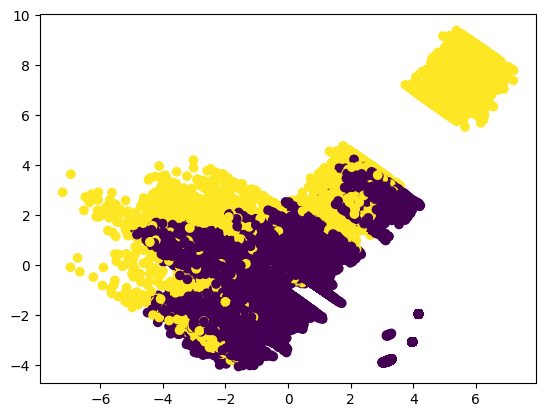

In [28]:
plt.scatter(x_after_pca_in_2D[:, 0], x_after_pca_in_2D[:, 1], c=df['label'].map({0: 0, 1: 1}))

In [29]:
pca = PCA()
pca.fit(ss.fit_transform(df[features_list].to_numpy()))

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    range_y=(0.98, 1.02),
    title="SVD Explained Variance Ratio"
)

As we can see we can compress the data into 30 components without losing any information.

## Train Test Split

*   x_Train and y_Train will be used for _Train_
*   x_test and y_test.T will be used for _Test_


In [30]:
# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list]   #.to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(118995, 48) (118995,)
(25505, 48) (25505,)


Counter({5: 1612,
         0: 128420,
         6: 3173,
         1: 3257,
         7: 3290,
         3: 1578,
         4: 1626,
         2: 1544})

In [31]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [32]:
pca = PCA(30)
pca.fit(X_train)
# x_train_pca = pca.transform(X_train)
x_train_pca_real = pca.transform(X_train)
x_train_pca = X_train

In [33]:
# x_test_pca = pca.transform(X_test)
x_test_pca_real = pca.transform(X_test)
x_test_pca = X_test

In [34]:
def plot_feature_importance(model):
    plt.figure(figsize=(10, 10))
    plt.title("Feature importance")
    plt.barh(range(x_train_pca.shape[1]), model.feature_importances_, align="center")
    plt.yticks(np.arange(x_train_pca.shape[1]), features_list)
    plt.ylim([-1, x_train_pca.shape[1]])
    plt.show()

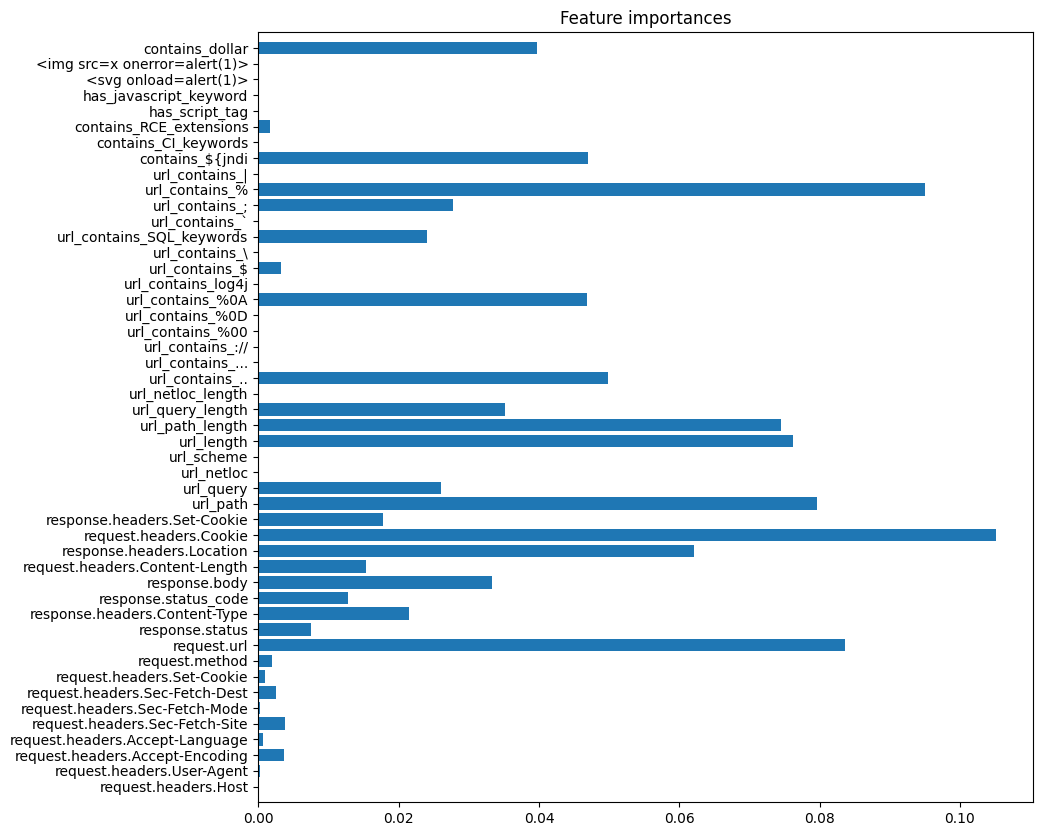

In [35]:
# Feature selection with Random Forest Classifier

rfc_fs = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_fs.fit(x_train_pca, y_train)

# Plot the feature importance of the forest

plot_feature_importance(rfc_fs)

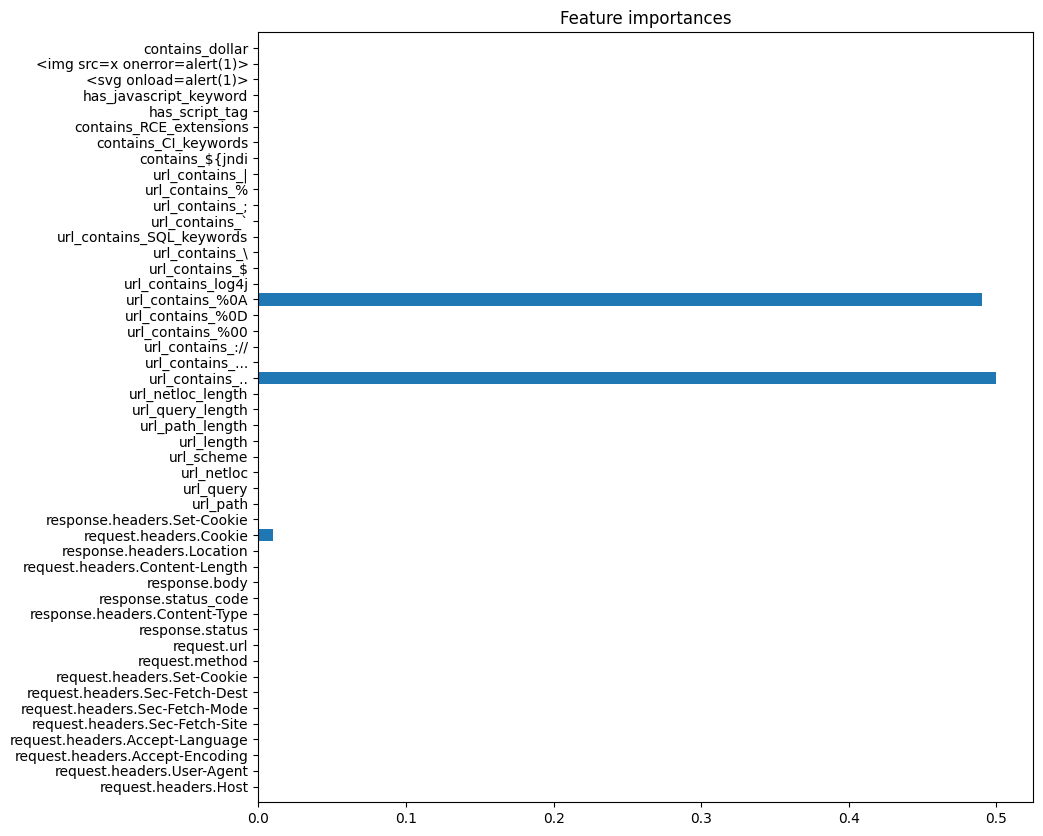

In [36]:
# Feature selection with AdaBoost Classifier

abc_fs = AdaBoostClassifier(n_estimators=100, random_state=42)
abc_fs.fit(x_train_pca, y_train)

# Plot the feature importance of the forest

plot_feature_importance(abc_fs)

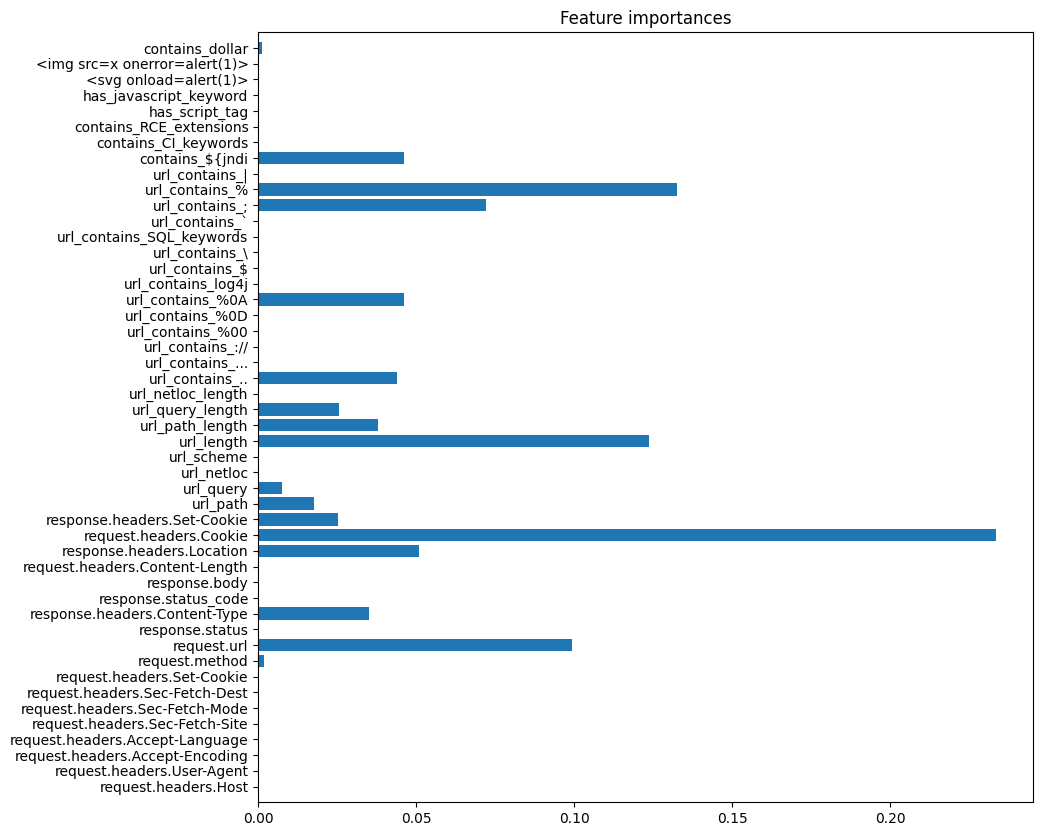

In [37]:
# Feature selection with Gradient Boosting Classifier

gbc_fs = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbc_fs.fit(x_train_pca, y_train)

# Plot the feature importance of the forest

plot_feature_importance(gbc_fs)

/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



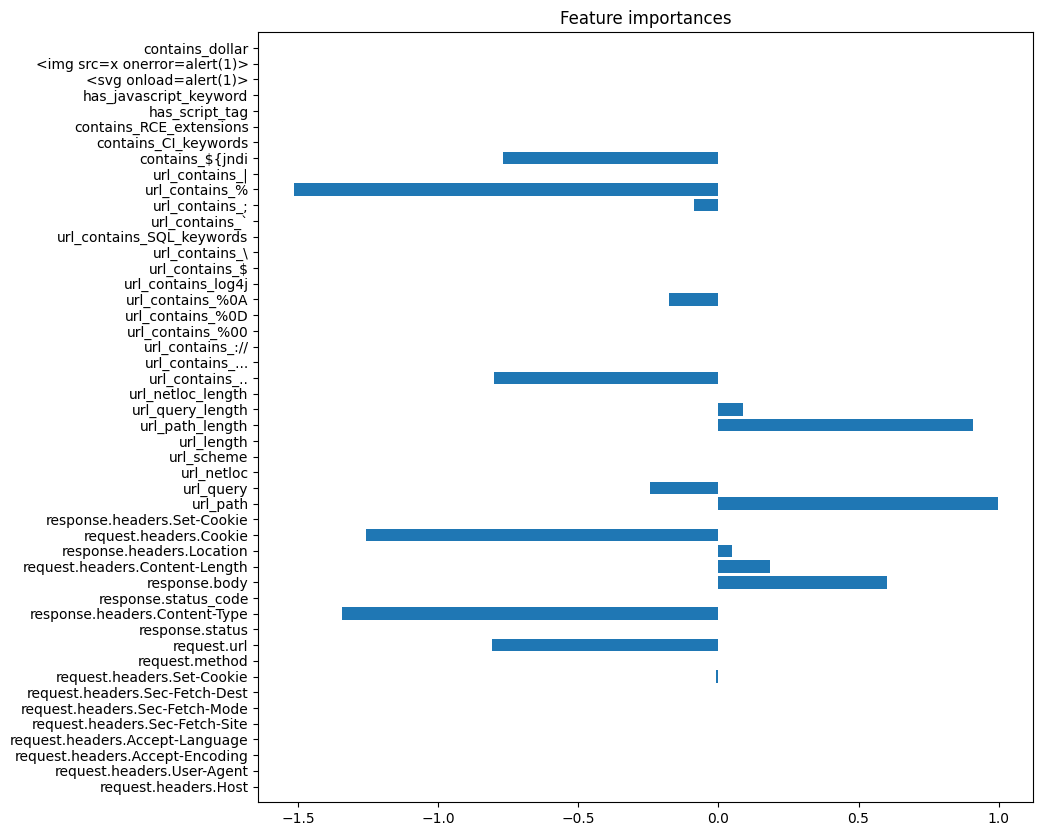

In [38]:
# Feature importance with Linear SVC
 
from sklearn.svm import LinearSVC
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(x_train_pca, y_train)
lsvc.coef_

# Plot feature importance with Linear SVC

plt.figure(figsize=(10, 10))
plt.title("Feature importance")
plt.barh(range(x_train_pca.shape[1]), lsvc.coef_[0], align="center")
plt.yticks(np.arange(x_train_pca.shape[1]), features_list)
plt.ylim([-1, x_train_pca.shape[1]])
plt.show()

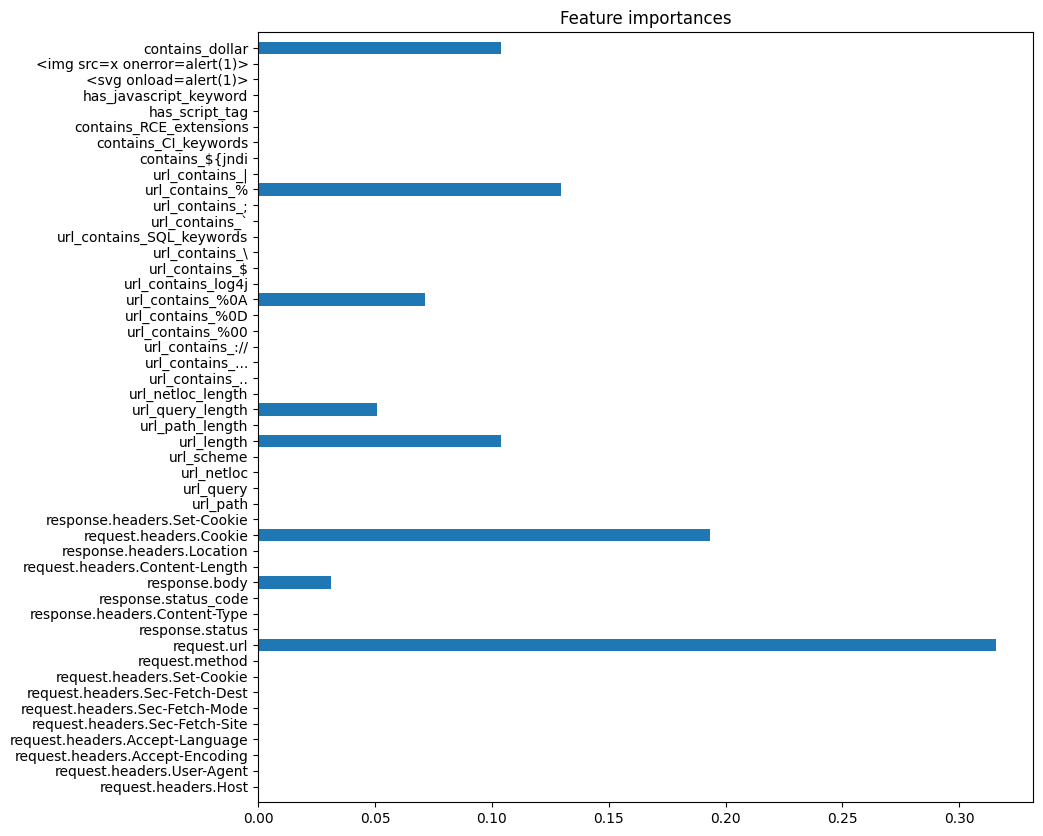

In [39]:
# Feature selection with Decision Tree Classifier

dtc_fs = DecisionTreeClassifier(random_state=42)
dtc_fs.fit(x_train_pca, y_train)

plot_feature_importance(dtc_fs)

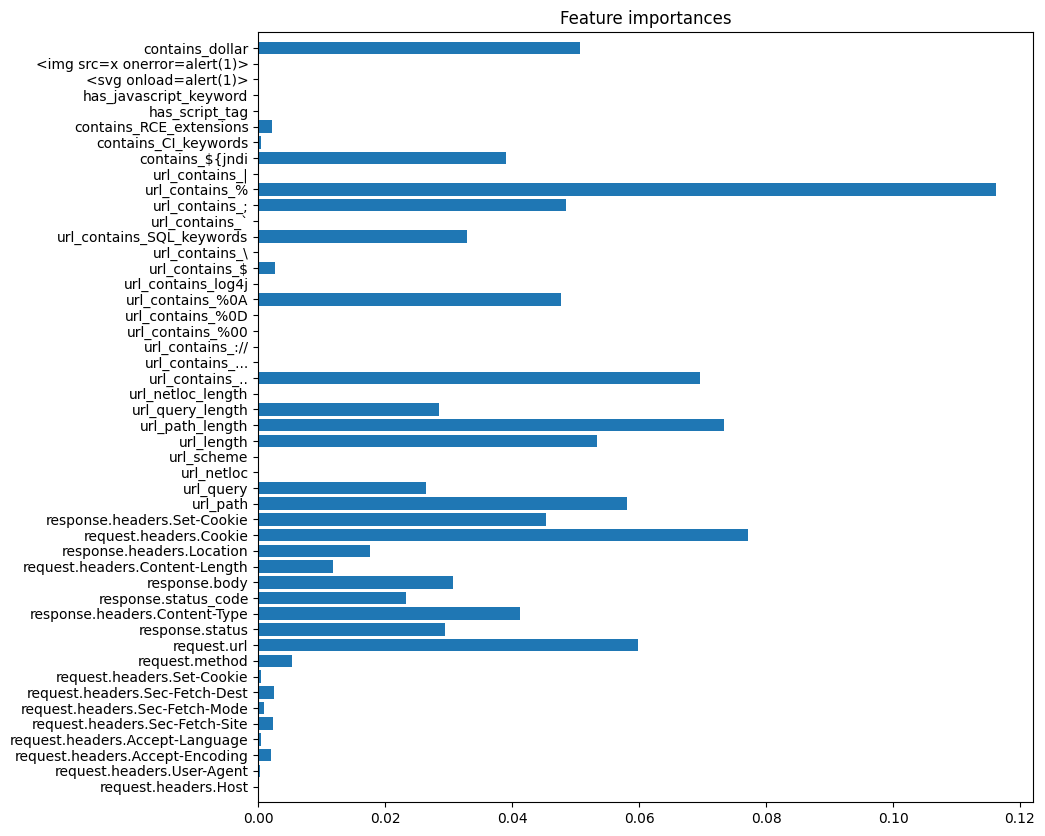

In [40]:
# Feature selection with Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier

etc_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
etc_fs.fit(x_train_pca, y_train)

plot_feature_importance(etc_fs)

In [41]:
# Print the feature ranking - Top 10
fs_table = pd.DataFrame(columns=['Feature', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Linear SVC', 'Decision Tree', 'Extra Trees'])
fs_table['Feature'] = features_list
fs_table['Random Forest'] = rfc_fs.feature_importances_

fs_table['AdaBoost'] = abc_fs.feature_importances_
fs_table['Gradient Boosting'] = gbc_fs.feature_importances_
fs_table['Linear SVC'] = np.abs(lsvc.coef_[0])
fs_table['Decision Tree'] = dtc_fs.feature_importances_
fs_table['Extra Trees'] = etc_fs.feature_importances_

fs_table['Mean'] = fs_table.mean(axis=1)
fs_table.sort_values(by='Mean', ascending=False, inplace=True)
fs_table.head(15)

/tmp/ipykernel_68056/907717656.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Feature,Random Forest,AdaBoost,Gradient Boosting,Linear SVC,Decision Tree,Extra Trees,Mean
38,url_contains_%,0.095063,0.00,0.132434,1.516178,0.129717,0.116292,0.331614
16,request.headers.Cookie,0.105216,0.01,0.233622,1.259334,0.193244,0.077147,0.313094
26,url_contains_..,0.049833,0.50,0.043954,0.801822,0.000000,0.069526,0.244189
11,response.headers.Content-Type,0.021465,0.00,0.035127,1.342003,0.000000,0.041157,0.239959
9,request.url,0.083583,0.00,0.099274,0.808288,0.315901,0.059882,0.227821
18,url_path,0.079653,0.00,0.017469,0.998234,0.000226,0.058068,0.192275
23,url_path_length,0.074496,0.00,0.037973,0.910246,0.000000,0.073338,0.182675
40,contains_${jndi,0.046939,0.00,0.046100,0.767810,0.000000,0.039040,0.149981
31,url_contains_%0A,0.046912,0.49,0.046169,0.178055,0.071474,0.047711,0.146720
13,response.body,0.033302,0.00,0.000191,0.601833,0.031215,0.030615,0.116193


In [42]:
# x_train_pca = x_train_pca[:, fs_table['Mean'].head(15).index]
# x_test_pca = x_test_pca[:, fs_table['Mean'].head(15).index]

Fitting estimator with 48 features.
Fitting estimator with 48 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 47 features.
Fitting estimator with 47 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 46 features.
Fitting estimator with 46 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 45 features.
Fitting estimator with 45 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 44 features.
Fitting estimator with 44 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 43 features.
Fitting estimator with 43 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 42 features.
Fitting estimator with 42 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 41 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 41 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 40 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 40 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 39 features.
Fitting estimator with 39 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 38 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 38 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 37 features.
Fitting estimator with 37 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 36 features.
Fitting estimator with 36 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 35 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 35 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 34 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 34 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 33 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 33 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 32 features.
Fitting estimator with 32 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 31 features.
Fitting estimator with 31 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 30 features.
Fitting estimator with 30 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 29 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 29 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 28 features.
Fitting estimator with 28 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 27 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 27 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 26 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 26 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 25 features.
Fitting estimator with 25 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 24 features.
Fitting estimator with 24 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 23 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 23 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 22 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 22 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 21 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 21 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 20 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 20 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 19 features.
Fitting estimator with 19 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 18 features.
Fitting estimator with 18 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 17 features.
Fitting estimator with 17 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 16 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 16 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 15 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 15 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 14 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 14 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 13 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 13 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 12 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 12 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 11 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 11 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 10 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 10 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 9 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 9 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 8 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 8 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 7 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 7 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 6 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 6 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 5 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 5 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 4 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 4 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 3 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 3 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 2 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting estimator with 2 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Fitting estimator with 48 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 47 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 46 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 45 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 44 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 43 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 42 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 41 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 40 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 39 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 38 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 37 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 36 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 35 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 34 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 33 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 32 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 31 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 30 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 29 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 28 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 27 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 26 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 25 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 24 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 23 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 22 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 21 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fitting estimator with 20 features.


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Optimal number of features : 19


/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning:

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.



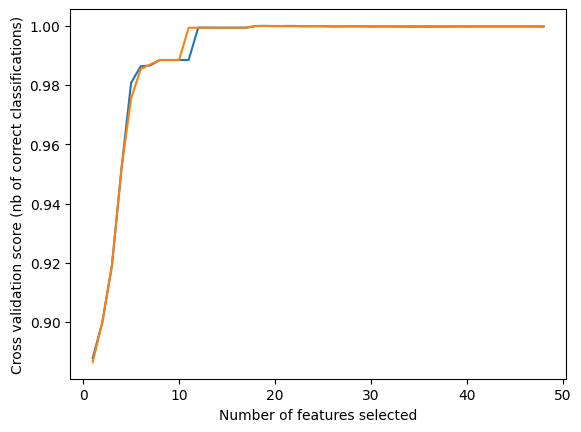

In [43]:
# Feature selection

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
recall_scorer = make_scorer(recall_score, pos_label='Malware')
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=StratifiedKFold(2), scoring='accuracy', verbose=1, n_jobs=-1)
rfecv.fit(x_train_pca, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

x_train_pca = rfecv.transform(x_train_pca)
x_test_pca = rfecv.transform(x_test_pca)

In [44]:
def create_grid_search(model, params):
    # Create a grid search object which is used to find the best hyperparameters for the model
    return GridSearchCV(estimator=model,
                        param_grid=params,
                        n_jobs=-1,
                        verbose=3,
                        cv=3,
                        scoring='accuracy',
                        return_train_score=True)

In [45]:
# https://plotly.com/python/parallel-categories-diagram/

def plot_grid_search_results(results):

    df = pd.DataFrame(results)

    # Build parcats dimensions
    categorical_dimensions = [c for c in df.columns if "param_" in c]

    dimensions = [dict(values=df[label], label=label)for label in categorical_dimensions]

    # Build color scale
    color = np.zeros(len(df), dtype='uint8')
    colorscale = [[0, 'gray'], [1, 'blue']]

    # Build figure as FigureWidget
    fig = go.FigureWidget(data=[go.Scatter(x=df['std_test_score'], y=df['mean_test_score'], marker={'color': 'gray'}, mode='markers', selected={'marker': {'color': 'blue'}}, unselected={'marker': {'opacity': 0.3}}), go.Parcats(domain={'y': [0, 0.4]}, dimensions=dimensions,line={'colorscale': colorscale, 'cmin': 0,'cmax': 1, 'color': color, 'shape': 'hspline'})])

    fig.update_layout(
        height=800, xaxis={'title': 'STD Score'},
        yaxis={'title': 'Mean Score', 'domain': [0.6, 1]},
        dragmode='lasso', hovermode='closest')

    # Update color callback
    def update_color(points):
        # Update scatter selection
        fig.data[0].selectedpoints = points.point_inds

        # Update parcats colors
        new_color = np.zeros(len(df), dtype='uint8')
        new_color[points.point_inds] = 1
        fig.data[1].line.color = new_color

    # Register callback on scatter selection...
    fig.data[0].on_selection(update_color)

    # and parcats click
    fig.data[1].on_click(update_color)

    return fig

### Model Choosing & Fitting


#### Random Forest

Ensemble learning method that uses multiple decision trees to make predictions.
It is a robust and flexible model that can handle high-dimensional and complex data,making it a good choice for API classification tasks.

In [ ]:
rf = RandomForestClassifier()
rf_param = {
    "n_estimators": [150, 250, 750],
    "criterion": ["gini", "entropy"],
    "max_depth": [20],
    "min_samples_split": [2],
    "random_state": [43],
}
rf_gcv = create_grid_search(rf, rf_param)

In [47]:
rf_gcv.fit(x_train_pca, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=150, random_state=43;, score=(train=1.000, test=1.000) total time=  16.8s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=150, random_state=43;, score=(train=1.000, test=1.000) total time=  17.2s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=150, random_state=43;, score=(train=1.000, test=1.000) total time=  22.4s
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=250, random_state=43;, score=(train=1.000, test=1.000) total time=  31.4s
[CV 2/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=250, random_state=43;, score=(train=1.000, test=1.000) total time=  31.5s
[CV 3/3] END criterion=gini, max_depth=20, min_samples_split=2, n_estimators=250, random_state=43;, score=(train=1.000, test=1.000) total time=  33.2s
[CV 1/3] END criterion=entropy, ma

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [20],
                         'min_samples_split': [2],
                         'n_estimators': [150, 250, 750],
                         'random_state': [43]},
             return_train_score=True, scoring='accuracy', verbose=3)

In [48]:
# plot_grid_search_results(rf_gcv.cv_results_)

In [49]:
print("Best parameters: ", rf_gcv.best_params_)

Best parameters:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 43}


In [50]:
clf = rf_gcv.best_estimator_

In [51]:
# Save the model
filename = "Model/"+str(dataset_number)+"/rf"+str(dataset_number)+"_model_label.sav"
pickle.dump(clf, open(filename, 'wb'))

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000     22667
           1    1.00000   1.00000   1.00000       575
           2    1.00000   1.00000   1.00000       272
           3    1.00000   1.00000   1.00000       278
           4    1.00000   1.00000   1.00000       287
           5    1.00000   1.00000   1.00000       285
           6    1.00000   1.00000   1.00000       560
           7    1.00000   1.00000   1.00000       581

    accuracy                        1.00000     25505
   macro avg    1.00000   1.00000   1.00000     25505
weighted avg    1.00000   1.00000   1.00000     25505



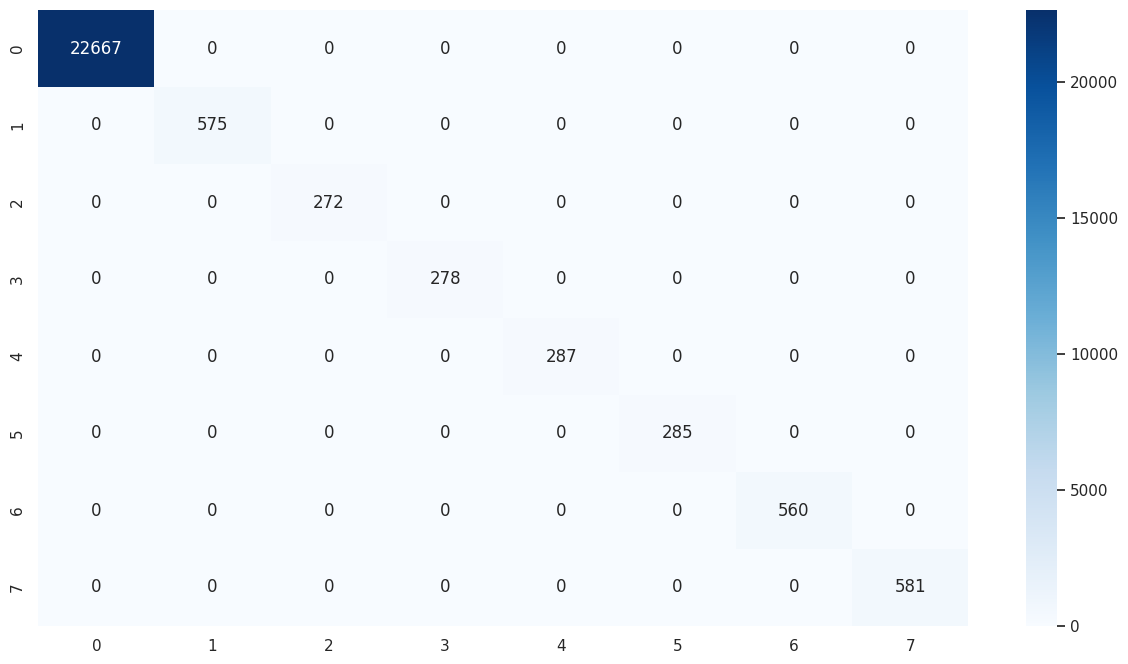

In [52]:
show(clf)

#### Result


In [53]:
def show(model):
    # We print our results
    sns.set(rc={'figure.figsize': (15, 8)})
    predictions = model.predict(x_test_pca)
    true_labels = y_test
    cf_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))

    # The heatmap is cool but this is the most important result
    print(model_report)

## Test


In [54]:
# Read the valuation json, preprocess it and run your model
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset -- Remember here you don't have the labels
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')

create_features(test_df)
test_df = vectorize_df(test_df)

X = test_df[features_list].to_numpy()
X = ss.transform(X)
X = rfecv.transform(X)
predictions = clf.predict(X)

/home/nonofurbuisness/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



### Save predictions

In [69]:
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt',
           enc.fit_transform(predictions), fmt='%2d')